In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


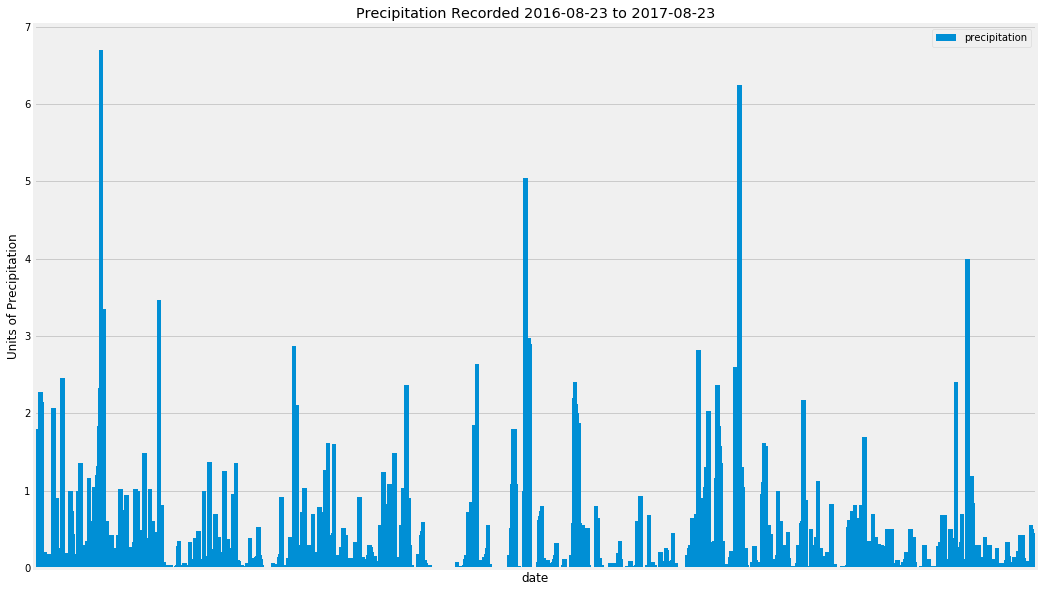

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# trying not to hardcode by using date, but relying on format 'y-m-d'  
ymd = latest[0].split('-')
querydate = dt.date(int(ymd[0]), int(ymd[1]), int(ymd[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcpinfo = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= querydate).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcpinfo, columns=['date','precipitation'])
#prcp_df['date']=pd.DatetimeIndex(prcp_df['date'])
prcp_df['date']=pd.to_datetime(prcp_df['date'], infer_datetime_format=True)
prcp_df= prcp_df.set_index('date')


# Sort the dataframe by date - already sorted from query
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='bar', figsize=(16,10), width=10)
plt.xticks([])
plt.ylabel("Units of Precipitation")
plt.title(f'Precipitation Recorded {querydate.strftime("%Y-%m-%d")} to {latest[0]}')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
numstations = session.query(Measurement.station).group_by(Measurement.station).count()
numstations

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()[0]

'USC00519281'

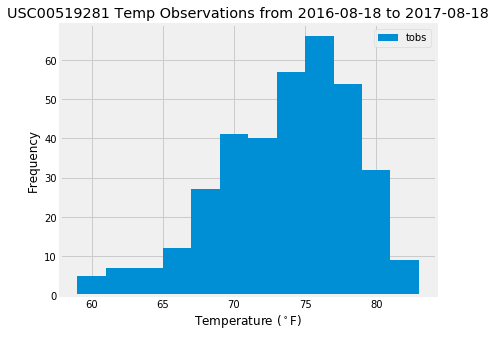

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
actstation = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()[0]
tlatest = session.query(Measurement.date).filter(Measurement.station==actstation).order_by(Measurement.date.desc()).first()
tlatest
# trying not to hardcode by using date, but relying on format 'y-m-d'  
tymd = tlatest[0].split('-')
tquerydate = dt.date(int(tymd[0]), int(tymd[1]), int(tymd[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the temperature observations
tobsinfo = session.query(Measurement.tobs).filter(Measurement.station==actstation).filter(Measurement.date >= tquerydate)
tobs_df = pd.DataFrame(tobsinfo, columns=['tobs'])
tobs_df['tobs'].hist(bins=12, label='tobs', figsize=(6,5))
plt.title(f'{actstation} Temp Observations from {tquerydate.strftime("%Y-%m-%d")} to {tlatest[0]}')
plt.xlabel('Temperature ($^\circ$F)')
plt.legend()
plt.ylabel('Frequency')
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin,tavg,tmax = calc_temps('2017-01-01', '2017-01-07')[0]
print(tmin,tavg,tmax)

62.0 68.36585365853658 74.0


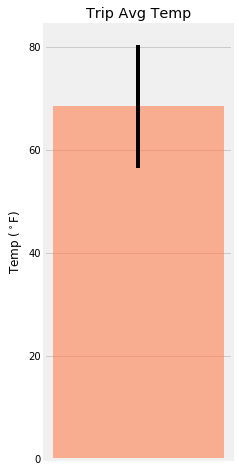

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,8))
plt.bar([0], [tavg],  yerr=(tmax-tmin), color =['coral'], alpha=.6)
plt.xticks([])
plt.yticks([0,20,40,60, 80])
plt.title("Trip Avg Temp")
plt.ylabel('Temp ($^\circ$F)')
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
start_date = '2017-01-01'
end_date = '2017-01-07'
results = session.query(*sel).filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
print(f"Results for {start_date} to {end_date}:")
print("-----")
for r in results:
    print(f"Station: {r[0]}")
    print(f"Name: {r[1]}")
    print(f"Lat: {r[2]}")
    print(f"Lng: {r[3]}")
    print(f"Elevation: {r[4]}")
    print(f"Total rainfall: {r[5]}")
    print("-----")

Results for 2017-01-01 to 2017-01-07:
-----
Station: USC00519523
Name: WAIMANALO EXPERIMENTAL FARM, HI US
Lat: 21.33556
Lng: -157.71139
Elevation: 19.5
Total rainfall: 0.61
-----
Station: USC00514830
Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Lat: 21.5213
Lng: -157.8374
Elevation: 7.0
Total rainfall: 0.6
-----
Station: USC00516128
Name: MANOA LYON ARBO 785.2, HI US
Lat: 21.3331
Lng: -157.8025
Elevation: 152.4
Total rainfall: 0.6
-----
Station: USC00513117
Name: KANEOHE 838.1, HI US
Lat: 21.4234
Lng: -157.8015
Elevation: 14.6
Total rainfall: 0.35
-----
Station: USC00519281
Name: WAIHEE 837.5, HI US
Lat: 21.45167
Lng: -157.84888999999998
Elevation: 32.9
Total rainfall: 0.2
-----
Station: USC00519397
Name: WAIKIKI 717.2, HI US
Lat: 21.2716
Lng: -157.8168
Elevation: 3.0
Total rainfall: 0.0
-----


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]

# Set the start and end date of the trip
# year out of range for measurements, but ok as normal function looking at month and day
start_date = '2018-01-01'
end_date = '2018-01-07'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start_date, "%Y-%m-%d")
end = dt.datetime.strptime(end_date, "%Y-%m-%d")+dt.timedelta(days=1)
daterange= [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

# Stip off the year and save a list of %m-%d strings
mddates = [date.strftime("%d-%m") for date in daterange]

# Loop through the list of %m-%d strings and calculate the normals for each date
for md in mddates:
    normals.append(daily_normals(md))

normals

[[(62.0, 69.15384615384616, 77.0)],
 [(56.0, 68.14035087719299, 78.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(60.0, 71.87931034482759, 80.0)],
 [(65.0, 72.75925925925925, 79.0)],
 [(64.0, 74.6140350877193, 81.0)],
 [(67.0, 74.77777777777777, 81.0)]]

In [42]:
# create dataframe

normalsall=[]
for i, date in enumerate(daterange):
    datedict={}
    datedict["date"]=date
    datedict["tmin"]=normals[i][0][0]
    datedict["tavg"]=normals[i][0][1]
    datedict["tmax"]=normals[i][0][2]
    normalsall.append(datedict)
    

normalsdf=pd.DataFrame(normalsall, columns=["date","tmin","tavg","tmax"]).set_index("date")
normalsdf

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,56.0,68.140351,78.0
2018-01-03,64.0,70.032787,76.0
2018-01-04,60.0,71.879310,80.0
2018-01-05,65.0,72.759259,79.0
2018-01-06,64.0,74.614035,81.0
2018-01-07,67.0,74.777778,81.0


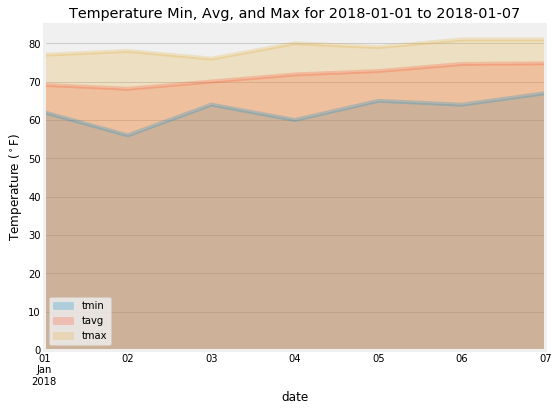

In [68]:
# Plot the daily normals as an area plot with `stacked=False`

normalsdf.plot.area(stacked=False, figsize=(8,6), alpha=.25)
plt.title(f"Temperature Min, Avg, and Max for {start_date} to {end_date}")
plt.ylabel("Temperature ($^\circ$F)")
plt.show()